## imports

In [2]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt


## Downloading photos

In [3]:
def clean_png_iccp(input_path, output_path):
    img = Image.open(input_path)
    img.save(output_path, icc_profile=None)


folder_path = 'dog_images/'
image_paths = sorted(glob.glob(os.path.join(folder_path, '*.*')))
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]
images = [img for img in images if img is not None]
print(f"Loaded {len(images)} images.")

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Loaded 60 images.


libpng warning: iCCP: known incorrect sRGB profile


## SIFT

In [ ]:
import sift

keypoints_list = []
descriptors_list = []

for idx, img in enumerate(images):
    kp, des = sift.computeKeypointsAndDescriptors(img)
    keypoints_list.append(kp)
    descriptors_list.append(des)
    print(f"Image {idx}: Detected {len(kp)} keypoints.")

Image 0: Detected 2029 keypoints.
Image 1: Detected 2149 keypoints.
Image 2: Detected 2512 keypoints.
Image 3: Detected 2934 keypoints.
Image 4: Detected 3148 keypoints.


In [5]:
sift = cv2.SIFT_create()

keypoints_list = []
descriptors_list = []

for idx, img in enumerate(images):
    kp, des = sift.detectAndCompute(img, None)
    keypoints_list.append(kp)
    descriptors_list.append(des)
    print(f"Image {idx}: Detected {len(kp)} keypoints.")

Image 0: Detected 2030 keypoints.
Image 1: Detected 2152 keypoints.
Image 2: Detected 2512 keypoints.
Image 3: Detected 2934 keypoints.
Image 4: Detected 3147 keypoints.
Image 5: Detected 3467 keypoints.
Image 6: Detected 3837 keypoints.
Image 7: Detected 3869 keypoints.
Image 8: Detected 3613 keypoints.
Image 9: Detected 3476 keypoints.
Image 10: Detected 3087 keypoints.
Image 11: Detected 2811 keypoints.
Image 12: Detected 2439 keypoints.
Image 13: Detected 2461 keypoints.
Image 14: Detected 2551 keypoints.
Image 15: Detected 2706 keypoints.
Image 16: Detected 2633 keypoints.
Image 17: Detected 2402 keypoints.
Image 18: Detected 2121 keypoints.
Image 19: Detected 2053 keypoints.
Image 20: Detected 2278 keypoints.
Image 21: Detected 2333 keypoints.
Image 22: Detected 2443 keypoints.
Image 23: Detected 2646 keypoints.
Image 24: Detected 2845 keypoints.
Image 25: Detected 3305 keypoints.
Image 26: Detected 3747 keypoints.
Image 27: Detected 3932 keypoints.
Image 28: Detected 4005 keypoi

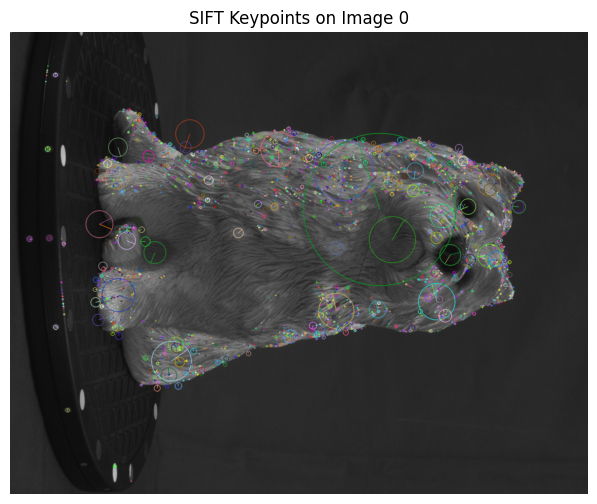

In [6]:
img_idx = 0
img = images[img_idx]
keypoints = keypoints_list[img_idx]

img_with_keypoints = cv2.drawKeypoints(
    img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.figure(figsize=(8, 6))
plt.imshow(img_with_keypoints, cmap='gray')
plt.title(f'SIFT Keypoints on Image {img_idx}')
plt.axis('off')
plt.show()

## KNN

In [35]:
def knn_match_manual(desc1, desc2, kp1, kp2, ratio_thresh=0.75):
    """
    Manual implementation of KNN matching + Lowe's ratio test.

    :param desc1: numpy array of descriptors from image 1 (shape: Nx128)
    :param desc2: numpy array of descriptors from image 2 (shape: Mx128)
    :param kp1: list of (x, y) coordinates for keypoints in image 1
    :param kp2: list of (x, y) coordinates for keypoints in image 2
    :param ratio_thresh: Lowe's ratio threshold (default: 0.75)
    :return: list of matched point pairs as (x1, y1, x2, y2)
    """
    matches = []

    for i, d1 in enumerate(desc1):
        # Compute L2 distances to all descriptors in image 2
        distances = np.linalg.norm(desc2 - d1, axis=1)

        # Find the two closest descriptors
        idx_sorted = np.argsort(distances)
        best_idx, second_idx = idx_sorted[0], idx_sorted[1]
        best_dist, second_dist = distances[best_idx], distances[second_idx]

        # Apply Lowe's ratio test
        if best_dist < ratio_thresh * second_dist:
            pt1 = kp1[i]
            pt2 = kp2[best_idx]
            matches.append((pt1[0], pt1[1], pt2[0], pt2[1]))

    return matches

knn_match_manual_desc1 = descriptors_list[0]
knn_match_manual_desc2 = descriptors_list[1]
kp1 = [kp.pt for kp in keypoints_list[0]]
kp2 = [kp.pt for kp in keypoints_list[1]]
matches = knn_match_manual(knn_match_manual_desc1, knn_match_manual_desc2, kp1, kp2)


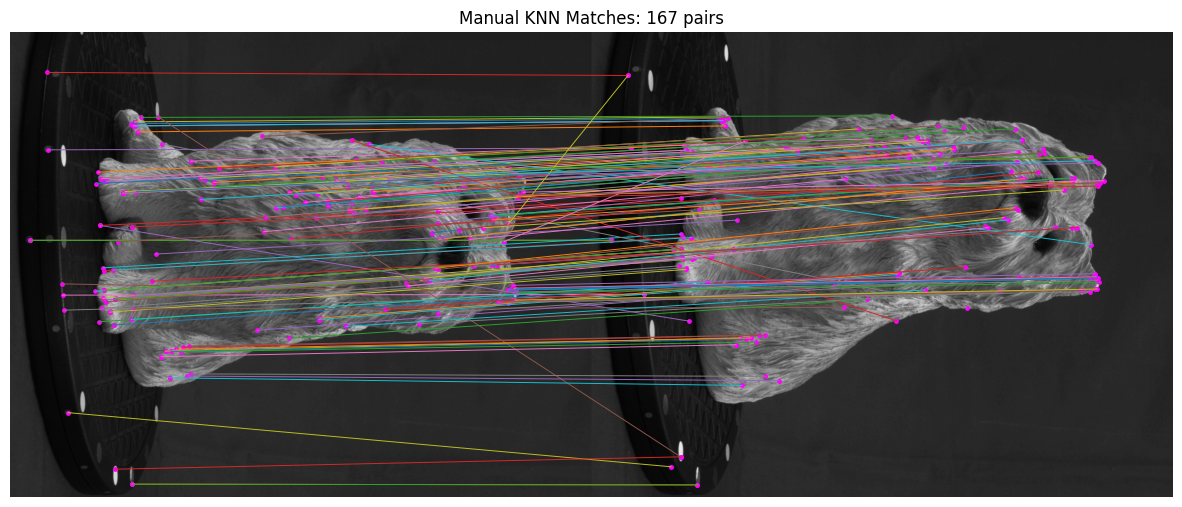

In [25]:
def plot_manual_knn_matches(img1, img2, matches):
    """
    Plot manually matched keypoints between two images side-by-side.
    
    :param img1: First grayscale image (left)
    :param img2: Second grayscale image (right)
    :param matches: List of tuples (x1, y1, x2, y2) representing matches
    """
    # Create side-by-side canvas
    height = max(img1.shape[0], img2.shape[0])
    width = img1.shape[1] + img2.shape[1]
    canvas = np.zeros((height, width), dtype=np.uint8)
    canvas[:img1.shape[0], :img1.shape[1]] = img1
    canvas[:img2.shape[0], img1.shape[1]:] = img2

    # Plot canvas
    plt.figure(figsize=(15, 8))
    plt.imshow(canvas, cmap='gray')
    plt.axis('off')

    # Plot matches
    for x1, y1, x2, y2 in matches:
        x2_shifted = x2 + img1.shape[1]
        plt.plot([x1, x2_shifted], [y1, y2], linewidth=0.7)
        plt.scatter([x1, x2_shifted], [y1, y2], c='magenta', s=6)

    plt.title(f"Manual KNN Matches: {len(matches)} pairs")
    plt.show()

# matches = knn_match_manual(desc1, desc2, kp1, kp2)
plot_manual_knn_matches(images[0], images[1], matches)


## RANSAC

In [42]:
import numpy as np

def to_homogeneous(pts):
    return np.hstack([pts, np.ones((pts.shape[0], 1))])

def normalize_points(pts):
    mean = np.mean(pts, axis=0)
    std = np.std(pts - mean)
    scale = np.sqrt(2) / std

    T = np.array([
        [scale,     0, -scale * mean[0]],
        [0,     scale, -scale * mean[1]],
        [0,         0,                1]
    ])

    pts_h = to_homogeneous(pts)
    pts_norm = (T @ pts_h.T).T

    return pts_norm[:, :2], T

def estimate_fundamental_matrix_normalized(pA, pB):
    pA_norm, TA = normalize_points(pA)
    pB_norm, TB = normalize_points(pB)

    A = np.array([
        [xB * xA, xB * yA, xB,
         yB * xA, yB * yA, yB,
         xA, yA, 1]
        for (xA, yA), (xB, yB) in zip(pA_norm, pB_norm)
    ])

    _, _, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)

    U, S, Vt = np.linalg.svd(F)
    S[2] = 0
    F_rank2 = U @ np.diag(S) @ Vt

    F_final = TB.T @ F_rank2 @ TA
    return F_final

def symmetric_epipolar_error(F, ptA, ptB):
    l1 = F @ ptA.T
    l2 = F.T @ ptB.T

    d1 = (ptB @ l1) ** 2 / (l1[0] ** 2 + l1[1] ** 2)
    d2 = (ptA @ l2) ** 2 / (l2[0] ** 2 + l2[1] ** 2)

    return float(d1 + d2)

def ransac_fundamental_matrix_advanced(
    matches,num_iter = 1000,threshold =1.0, seed = 42):
    np.random.seed(seed)

    if len(matches) < 8:
        raise ValueError("At least 8 matches are required.")

    ptsA = np.array([[x1, y1] for x1, y1, _, _ in matches])
    ptsB = np.array([[x2, y2] for _, _, x2, y2 in matches])
    ptsA_h = to_homogeneous(ptsA)
    ptsB_h = to_homogeneous(ptsB)

    best_F = None
    best_inliers = []

    for _ in range(num_iter):
        idx = np.random.choice(len(matches), size=8, replace=False)
        sampleA = ptsA[idx]
        sampleB = ptsB[idx]

        F_candidate = estimate_fundamental_matrix_normalized(sampleA, sampleB)

        errors = np.array([
            symmetric_epipolar_error(F_candidate, ptsA_h[i], ptsB_h[i])
            for i in range(len(matches))
        ])
        inliers = np.where(errors < threshold)[0]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_F = F_candidate

    if len(best_inliers) >= 8:
        best_F = estimate_fundamental_matrix_normalized(
            ptsA[best_inliers], ptsB[best_inliers]
        )

    return best_F, best_inliers

F, inlier_indices = ransac_fundamental_matrix_advanced(matches)
inlier_matches = [matches[i] for i in inlier_indices]
print(f"Matches before RANSAC: {len(matches)}")
print(f"Inliers after improved RANSAC: {len(inlier_matches)}")


Matches before RANSAC: 379
Inliers after improved RANSAC: 278


In [40]:
for i in range(len(images) - 1):
    img1, img2 = images[i], images[i+1]
    desc1, desc2 = descriptors_list[i], descriptors_list[i+1]
    kp1 = [kp.pt for kp in keypoints_list[i]]
    kp2 = [kp.pt for kp in keypoints_list[i+1]]

    matches = knn_match_manual(desc1, desc2, kp1, kp2)
    F, inlier_indices = ransac_fundamental_matrix_advanced(matches)

    print(f"Image pair ({i} ⇄ {i+1}):")
    print(f"  Total matches: {len(matches)}")
    print(f"  Inliers after RANSAC: {len(inlier_indices)}\n")


Image pair (0 ⇄ 1):
  Total matches: 167
  Inliers after RANSAC: 109

Image pair (1 ⇄ 2):
  Total matches: 138
  Inliers after RANSAC: 66

Image pair (2 ⇄ 3):
  Total matches: 166
  Inliers after RANSAC: 88

Image pair (3 ⇄ 4):
  Total matches: 215
  Inliers after RANSAC: 134

Image pair (4 ⇄ 5):
  Total matches: 224
  Inliers after RANSAC: 149

Image pair (5 ⇄ 6):
  Total matches: 365
  Inliers after RANSAC: 248

Image pair (6 ⇄ 7):
  Total matches: 590
  Inliers after RANSAC: 443

Image pair (7 ⇄ 8):
  Total matches: 618
  Inliers after RANSAC: 448

Image pair (8 ⇄ 9):
  Total matches: 385
  Inliers after RANSAC: 303

Image pair (9 ⇄ 10):
  Total matches: 604
  Inliers after RANSAC: 536

Image pair (10 ⇄ 11):
  Total matches: 389
  Inliers after RANSAC: 320

Image pair (11 ⇄ 12):
  Total matches: 498
  Inliers after RANSAC: 444

Image pair (12 ⇄ 13):
  Total matches: 457
  Inliers after RANSAC: 391

Image pair (13 ⇄ 14):
  Total matches: 390
  Inliers after RANSAC: 330

Image pair (1

## Track Formation

## SfM

## MVS

## Surface Reconstruction